In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import math 
import scipy as sp



In [494]:
def normalize(matrix):
    div=np.max(matrix)-np.min(matrix)
    if div ==0:
        div=1
    normalizedData = ((matrix-np.min(matrix))/div)*255
    return normalizedData

In [495]:
#Load images

snrImg = []
snrReconstruct = []

rootNoisy = "gr5/Noisy"
noisyImgs = glob.glob(f"{rootNoisy}/*.bmp") + glob.glob(f"{rootNoisy}/*.jpg") 

rootOriginal = "gr5/Original"
originalImgs = glob.glob(f"{rootOriginal}/*.bmp") + glob.glob(f"{rootOriginal}/*.jpg")

originalImgs.sort()
noisyImgs.sort()

KeyboardInterrupt: 

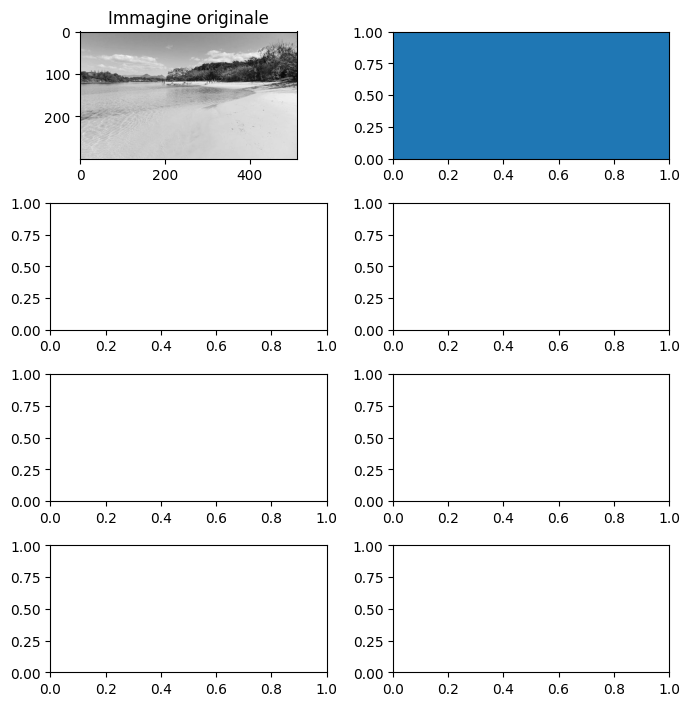

In [496]:
#presa un immagine definisco i tipi di rumore

img = cv2.imread(originalImgs[1],0)
np.random.seed(42)

#Rumore gaussiano
noise = np.random.normal(size=img.shape)
imgNoisyGauss = img + noise
imgNoisyGauss = cv2.normalize(imgNoisyGauss, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histOrig, bins = np.histogram(img.ravel(), bins=256, range=(0, 255))
histNoise, bins = np.histogram(imgNoisyGauss.ravel(), bins=256, range=(0, 255))

histNoiseOnlyGauss = histNoise - histOrig

#Rumore uniforme
low = 0
high = 255
noise = np.random.uniform(low, high, img.shape)
#noise = np.random.rand(*img.shape) * 255
imgNoisyUni = img + noise
imgNoisyUni = cv2.normalize(imgNoisyUni, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisyUni.ravel(), bins=256, range=(0, 255))
histNoiseOnlyUnif = histNoise - histOrig

#Rumore sale e pepe
x,y = img.shape
noise = np.random.rand(x,y)*255
salt = noise > 240
pepper = noise < 15
imgNoisySandP = img.copy()
imgNoisySandP[salt] = 255
imgNoisySandP[pepper] = 0
imgNoisySandP = cv2.normalize(imgNoisySandP, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

histNoise, bins = np.histogram(imgNoisySandP.ravel(), bins=256, range=(0, 255))

histNoiseOnlySandP = histNoise - histOrig

#matplot delle immagini con istogrammi
fig, axes = plt.subplots(4,2,figsize=(7,7))
fig.tight_layout()
axes[0][0].imshow(img, cmap="gray")
axes[0][0].set_title(f"Immagine originale")

axes[0][1].hist(img.ravel(),256,[0,256])
axes[0][1].set_title(f"Istogramma immagine originale")

axes[1][0].imshow(imgNoisyGauss, cmap="gray")
axes[1][0].set_title(f"Immagine rumorosa gauss")

axes[1][1].hist(histNoiseOnlyGauss,256,[0,256])
axes[1][1].set_title(f"Istogramma rumore gauss")

axes[2][0].imshow(imgNoisyUni, cmap="gray")
axes[2][0].set_title(f"Immagine rumorosa uniforme ")

axes[2][1].hist(histNoiseOnlyUnif,256,[0,256])
axes[2][1].set_title(f"Istogramma rumore uniforme ")

axes[3][0].imshow(imgNoisySandP, cmap="gray")
axes[3][0].set_title(f"Immagine rumorosa sale e pepe ")

axes[3][1].hist(histNoiseOnlySandP,256,[0,256])
axes[3][1].set_title(f"Istogramma rumore sale e pepe ")

plt.show()

In [ ]:
#Gaussian filter
def gauss(sigma,x):
    ''' 
    Input: sigma: Value of sigma for Gauss function, x: Centered value to apply Gauss

    Output: Gauss function applied to sigma and x
    '''
    gauss = 1/(math.sqrt(2*math.pi)*sigma)*math.e**(-(x**2/(2*sigma**2)))
    return gauss

def createMask(maskSize, sigma):
    ''' 
    Input: maskSize: Dimension for the mask, sigma: Value of sigma for Gauss function

    Output: Mask 
    '''
    mask = np.zeros([maskSize + 1, maskSize +1], dtype = float)
    centre = int(maskSize / 2) + 1
    for i in range(1, maskSize +1):
        for j in range(1, maskSize +1):
            dist = np.sqrt(np.power(abs(i-centre),2)+np.power(abs(j-centre),2))
            mask[i][j] = gauss(sigma, dist)
    return mask


def gaussianFilter(maskSize = 3, sigma = 15):
    img = cv2.imread(noisyImgs[1],0)
    mask = createMask(maskSize, sigma)
    conv=sp.signal.convolve2d(img, mask,'same')
    plt.figure()
    plt.imshow(conv,cmap="gray")
    
gaussianFilter()


In [ ]:
def medianFilter(maskSize = 3):
    img = cv2.imread(noisyImgs[5],0)
    m, n = np.shape(img)
    median = np.zeros_like(img)
    for i in range(1,m-1):
      for j in range (1,n-1):
         l = img[i:i + maskSize, j:j + maskSize].ravel()
         median[i,j] = np.mean(l)
    plt.figure()
    plt.imshow(median,cmap="gray")

medianFilter()


In [524]:
def denoiseImage(X, iter=4, WEd=1, WEp=0.3, exp=0.35):
  ''' 
  input: X np array for an image, iter int for number of iteration, WEp weight for data penalty

  output: Denoised imaged
  '''
  Y = np.copy(X)
  intesities = np.arange(256)
  mask = np.array([[0,1,0],[1,0,1],[0,1,0]])
  mask = mask * WEp

  for iteration in range(iter):
  
    print(f'Iteration in progress: {iteration+1}/{iter}               ', end="\r")
    
    #Fare quattro matrici (una per pixel in cui si va a finire)

    #poi si somma il pixel interessato moltiplicato per il coefficente
    energyMatrix = []

    for i in intesities:
      matrix = abs(Y-i)
      conv = cv2.filter2D(matrix, ddepth=-1, kernel=mask)
      tryIntensityEp = conv
      tryIntensityEp = np.power(tryIntensityEp,exp)
      tryIntensityEd = np.sqrt(matrix**2)
      sum = tryIntensityEp + tryIntensityEd
      energyMatrix.append(sum)
    
    energyMatrix = np.asarray(energyMatrix)
    #minEnergy = np.min(energyMatrix)
    #minIndex = np.argmin(energyMatrix)

   # Y = energyMatrix[1,:,:]
    



    for i in range(255):
      Y = np.fmin(Y, energyMatrix[i,:,:])
    #x,y,z = np.shape(energyMatrix)
    #for i in range(y):
    #  for j in range(z):
    #    Y[i,j] = np.min(energyMatrix[:,i,j])

    
    #print(minIndex.shape, minEnergy.shape)
    #Y = energyMatrix[minIndex,:,:]
    #input("?")
    energyMatrix=[]
    
  #Y = normalize(Y)
  #print(f"\n\n {np.shape(Y)}")
  return Y.astype(dtype=np.uint8)


In [529]:
reconstructedImgs = []
#for i in range(len(originalImgs)):
for i in range(1):
    print(f"image#:{i}                    ")
    imgOriginal = cv2.imread(originalImgs[i],0)
    imgNoisy = cv2.imread(noisyImgs[i],0)
    
    reconstructedImgs.append(denoiseImage(imgNoisy, exp = 0.8 ,iter = 15, WEp=0.25))
'''
fig, axes = plt.subplots(3,1,figsize=(10,10))
fig.tight_layout()
axes[0].imshow(imgOriginal,cmap="gray")
axes[0].set_title('Original Image')
axes[1].imshow(imgNoisy,cmap="gray")
axes[1].set_title('Noisy Image')
axes[2].imshow(imgReconstructed, cmap="gray")
axes[2].set_title('Denoised Image')
plt.show()
'''

image#:0                    


'\nfig, axes = plt.subplots(3,1,figsize=(10,10))\nfig.tight_layout()\naxes[0].imshow(imgOriginal,cmap="gray")\naxes[0].set_title(\'Original Image\')\naxes[1].imshow(imgNoisy,cmap="gray")\naxes[1].set_title(\'Noisy Image\')\naxes[2].imshow(imgReconstructed, cmap="gray")\naxes[2].set_title(\'Denoised Image\')\nplt.show()\n'

In [530]:

def PSNR(x1, x2):
    mse = np.mean((x1 - x2) ** 2)
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / np.sqrt(mse))
    return psnr

for i in range(len(reconstructedImgs)):
    imgOriginal = cv2.imread(originalImgs[i],0)
    imgNoisy = cv2.imread(noisyImgs[i],0)
    PSNRDenoisedNoisy = PSNR(reconstructedImgs[i], imgNoisy)
    PSNROriginalyNoisy = PSNR(imgOriginal, imgNoisy)
    print(f"Image#:{i} \n    PSNR from denoised to noisy: {round(PSNRDenoisedNoisy,3)} dB\n    PSNR from original to noisy: {round(PSNROriginalyNoisy,3)} dB")

Image#:0 
    PSNR from denoised to noisy: 28.011 dB
    PSNR from original to noisy: 28.08 dB


In [533]:
for i in range(len(reconstructedImgs)):

    cv2.imwrite(f"denoisedImages/DenoisedImage#{i}.jpeg",reconstructedImgs[i])


In [534]:
a = abs(imgNoisy - reconstructedImgs[0])
for i in reconstructedImgs[0]:
    print (i) 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 